In [24]:
import os
import numpy as np
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Path dataset split
dataset_path = r'D:\Dataset Aksara Optimized\Datasets_split_aksaraBali702010'


In [25]:
# ImageDataGenerator for augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Dataset paths
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

Found 3140 images belonging to 18 classes.
Found 894 images belonging to 18 classes.
Found 459 images belonging to 18 classes.


In [26]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [27]:
# Load MobileNet as the base model without the classification layer
def create_model(trainable_from_layer, learning_rate):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Set trainable layers
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[trainable_from_layer:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(18, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


#### SKENARIO 1
mengatur layer-layer depan dari model MobileNet sebagai trainable (dapat di-train), sementara layer-layer lainnya akan di-freeze (tidak di-train). 
LR 1e-5



In [28]:
# Model 1: Train front layers (from layer 0 to 40)
model1 = create_model(trainable_from_layer=0, learning_rate=1e-5)
for layer in model1.layers[:41]:
    layer.trainable = True
model1.summary()
history1 = model1.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,247,314 (12.39 MB)

 Trainable params: 3,225,426 (12.30 MB)

 Non-trainable params: 21,888 (85.50 KB)

Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 86s 709ms/step - accuracy: 0.0650 - loss: 3.6614 - val_accuracy: 0.1018 - val_loss: 3.1171
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 672ms/step - accuracy: 0.1274 - loss: 2.9657 - val_accuracy: 0.1801 - val_loss: 2.5906
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 670ms/step - accuracy: 0.2410 - loss: 2.5026 - val_accuracy: 0.3031 - val_loss: 2.1726
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 672ms/step - accuracy: 0.3008 - loss: 2.1624 - val_accuracy: 0.4016 - val_loss: 1.8539
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 68s 672ms/step - accuracy: 0.4178 - loss: 1.8754 - val_accuracy: 0.4832 - val_loss: 1.5857
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 71s 708ms/step - accuracy: 0.4874 - loss: 1.6256 - val_accuracy: 0.5671 - val_loss: 1.3621
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 68s 680ms/step - accuracy: 0.5425 - loss: 1.4495 - val_accuracy: 0.6186 - val_loss: 1.1898
Epoch 8/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 68s 678ms/step - accuracy: 0.5910 - loss: 1.3102 - val_accu

In [29]:
# Output training and validation accuracy and loss
train_accuracy1 = history1.history['accuracy']
val_accuracy1 = history1.history['val_accuracy']
train_loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

print(f"Training Accuracy: {train_accuracy1[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracy1[-1]:.4f}")
print(f"Training Loss: {train_loss1[-1]:.4f}")
print(f"Validation Loss: {val_loss1[-1]:.4f}")


Training Accuracy: 0.9210
Validation Accuracy: 0.9452
Training Loss: 0.2779
Validation Loss: 0.2003


#### SKENARIO 2
mengatur layer-layer belakang dari model MobileNet sebagai trainable (dapat di-train), sementara layer-layer lainnya akan di-freeze (tidak di-train). 
LR 1e-4



In [30]:
# Model 2: Train back layers (from layer 41 to end)
model2 = create_model(trainable_from_layer=41, learning_rate=1e-4)
for layer in model2.layers[41:]:
    layer.trainable = True
model2.summary()
history2 = model2.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,247,314 (12.39 MB)

 Trainable params: 2,957,330 (11.28 MB)

 Non-trainable params: 289,984 (1.11 MB)

Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 421ms/step - accuracy: 0.2651 - loss: 2.6411 - val_accuracy: 0.5470 - val_loss: 1.3162
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 40s 401ms/step - accuracy: 0.7791 - loss: 0.7088 - val_accuracy: 0.8289 - val_loss: 0.5495
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 40s 400ms/step - accuracy: 0.8947 - loss: 0.3710 - val_accuracy: 0.9262 - val_loss: 0.2372
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 40s 400ms/step - accuracy: 0.9210 - loss: 0.2743 - val_accuracy: 0.9586 - val_loss: 0.1605
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 404ms/step - accuracy: 0.9290 - loss: 0.2182 - val_accuracy: 0.9676 - val_loss: 0.1186
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 402ms/step - accuracy: 0.9551 - loss: 0.1695 - val_accuracy: 0.9709 - val_loss: 0.1003
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 404ms/step - accuracy: 0.9615 - loss: 0.1444 - val_accuracy: 0.9664 - val_loss: 0.1074
Epoch 8/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 40s 400ms/step - accuracy: 0.9685 - loss: 0.1186 - val_accu

In [31]:
# Output training and validation accuracy and loss
train_accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

print(f"Training Accuracy: {train_accuracy2[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracy2[-1]:.4f}")
print(f"Training Loss: {train_loss2[-1]:.4f}")
print(f"Validation Loss: {val_loss2[-1]:.4f}")


Training Accuracy: 0.9850
Validation Accuracy: 0.9754
Training Loss: 0.0409
Validation Loss: 0.0545


#### SKENARIO 3
mengatur layer-layer depan dan belakang dari model MobileNet sebagai trainable 
:41 akan LR = 1e-5
82: akan LR = 1e-4



In [32]:
# Skenario 3: Set layers before 41 with 1e-5 and from 41 onwards with 1e-4
model3 = create_model(trainable_from_layer=41, learning_rate=1e-4)
for layer in model3.layers[:41]:
    layer.trainable = True
    layer.learning_rate = 1e-5
for layer in model3.layers[41:]:
    layer.trainable = True
    layer.learning_rate = 1e-4

model3.summary()

# Melatih model
history3 = model3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,247,314 (12.39 MB)

 Trainable params: 3,225,426 (12.30 MB)

 Non-trainable params: 21,888 (85.50 KB)

Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 82s 682ms/step - accuracy: 0.2201 - loss: 2.7400 - val_accuracy: 0.5638 - val_loss: 1.2929
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 672ms/step - accuracy: 0.7392 - loss: 0.8147 - val_accuracy: 0.8356 - val_loss: 0.5312
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 672ms/step - accuracy: 0.8769 - loss: 0.4232 - val_accuracy: 0.9262 - val_loss: 0.2581
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 670ms/step - accuracy: 0.9187 - loss: 0.2806 - val_accuracy: 0.9564 - val_loss: 0.1670
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 671ms/step - accuracy: 0.9394 - loss: 0.2156 - val_accuracy: 0.9474 - val_loss: 0.1606


In [33]:
# Output training and validation accuracy and loss
train_accuracy3 = history3.history['accuracy']
val_accuracy3 = history3.history['val_accuracy']
train_loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

print(f"Training Accuracy: {train_accuracy3[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracy3[-1]:.4f}")
print(f"Training Loss: {train_loss3[-1]:.4f}")
print(f"Validation Loss: {val_loss3[-1]:.4f}")


Training Accuracy: 0.9363
Validation Accuracy: 0.9474
Training Loss: 0.2153
Validation Loss: 0.1606


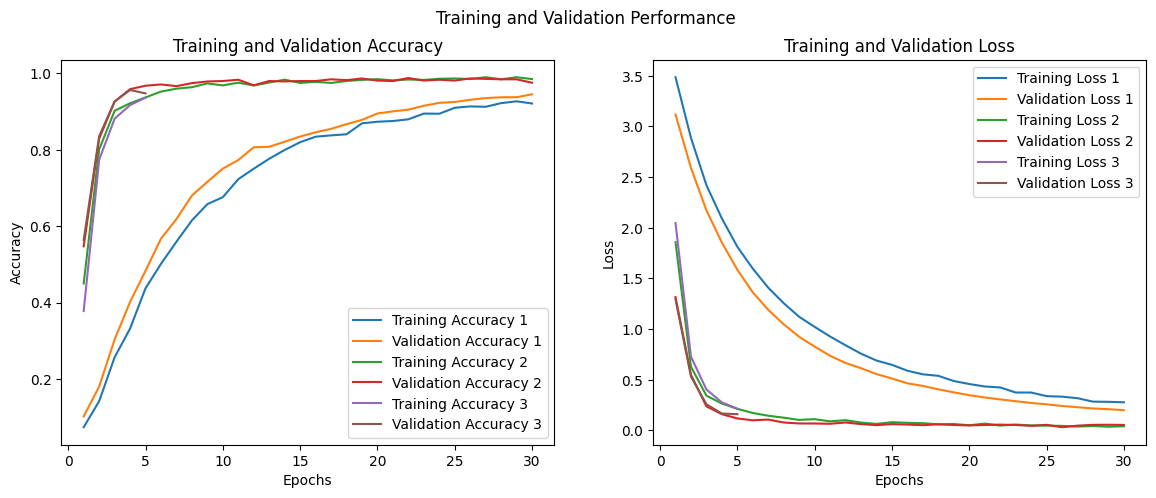

In [34]:
import matplotlib.pyplot as plt

def plot_history(histories, title):
    plt.figure(figsize=(14, 5))

    for i, history in enumerate(histories):
        epochs = range(1, len(history.history['accuracy']) + 1)
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history.history['accuracy'], label=f'Training Accuracy {i+1}')
        plt.plot(epochs, history.history['val_accuracy'], label=f'Validation Accuracy {i+1}')
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history.history['loss'], label=f'Training Loss {i+1}')
        plt.plot(epochs, history.history['val_loss'], label=f'Validation Loss {i+1}')

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(title)
    plt.show()

# Memanggil fungsi plot_history dengan histories yang tersedia
plot_history([history1, history2, history3], 'Training and Validation Performance')


In [35]:
# Evaluate on test data for each model
test_loss1, test_accuracy1 = model1.evaluate(test_generator)
test_loss2, test_accuracy2 = model2.evaluate(test_generator)
test_loss3, test_accuracy3 = model3.evaluate(test_generator)

print(f"Model 1 - Test Accuracy: {test_accuracy1:.4f}, Test Loss: {test_loss1:.4f}")
print(f"Model 2 - Test Accuracy: {test_accuracy2:.4f}, Test Loss: {test_loss2:.4f}")
print(f"Model 3 - Test Accuracy: {test_accuracy3:.4f}, Test Loss: {test_loss3:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - accuracy: 0.9450 - loss: 0.2172
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9829 - loss: 0.0586
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.5527 - loss: 1.3403
Model 1 - Test Accuracy: 0.9368, Test Loss: 0.2384
Model 2 - Test Accuracy: 0.9869, Test Loss: 0.0416
Model 3 - Test Accuracy: 0.5795, Test Loss: 1.2863


#### SAVE MODEL

In [37]:
# # # Save the model
model1.save('AksaraBaliOptimizedVer2.1.h5')
model2.save('AksaraBaliOptimizedVer2.2.h5')
model3.save('AksaraBaliOptimizedVer2.3.h5')